In [ ]:
import os
import re
import rasterio
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
import numpy as np
from sklearn.model_selection import train_test_split

Обнаружен файл: /home/user/projects/co_hack_fires/test_dataset_minprirody_test_dataset/test.tiff
File Path: /home/user/projects/co_hack_fires/test_dataset_minprirody_test_dataset/test.tiff
Driver: GTiff
Width: 516
Height: 316
Count (Bands): 4
CRS: None
Transform: | 10.00, 0.00, 0.00|
| 0.00,-10.00, 0.00|
| 0.00, 0.00, 1.00|
Bounding Box: BoundingBox(left=0.0, bottom=-3160.0, right=5160.0, top=0.0)
Datum: ('float32', 'float32', 'float32', 'float32')

Band 1:
  Data Type: float32
  Min Value: 0.0
  Max Value: 44.0
  Mean Value: 8.811193466186523
  Standard Deviation: 2.267102003097534

Band 2:
  Data Type: float32
  Min Value: 0.0
  Max Value: 40.0
  Mean Value: 15.68852424621582
  Standard Deviation: 3.6198506355285645

Band 3:
  Data Type: float32
  Min Value: 0.0
  Max Value: 57.0
  Mean Value: 18.702402114868164
  Standard Deviation: 4.5382561683654785

Band 4:
  Data Type: float32
  Min Value: 0.0
  Max Value: 126.0
  Mean Value: 58.862972259521484
  Standard Deviation: 14.220089912

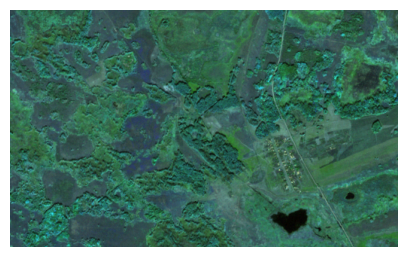

In [4]:
def find_tiff_file(directory):
    """Находит первый .tiff файл в указанной директории с помощью регулярного выражения"""
    tiff_pattern = re.compile(r'.*\.tiff$')  # Регулярное выражение для поиска .tiff файлов
    for file_name in os.listdir(directory):
        if tiff_pattern.match(file_name):
            return os.path.join(directory, file_name)
    raise FileNotFoundError("TIFF файл не найден в указанной директории")

def normalize_band(band):
    """Нормализует данные канала в диапазоне 0-255"""
    band_min, band_max = band.min(), band.max()
    normalized_band = (band - band_min) / (band_max - band_min) * 255.0
    return normalized_band.astype(np.uint8)

def visualize_rgb_geotiff(directory, r_band, g_band, b_band, ik_band, mask_band):
    try:
        # Поиск .tiff файла в указанной папке
        file_path = find_tiff_file(directory)
        print(f"Обнаружен файл: {file_path}")

        with rasterio.open(file_path) as src:

            print(f"File Path: {file_path}")
            print(f"Driver: {src.driver}")
            print(f"Width: {src.width}")
            print(f"Height: {src.height}")
            print(f"Count (Bands): {src.count}")
            print(f"CRS: {src.crs}")
            print(f"Transform: {src.transform}")
            print(f"Bounding Box: {src.bounds}")
            print(f"Datum: {src.dtypes}")

            for i in range(1, src.count + 1):
                band = src.read(i)
                print(f"\nBand {i}:")
                print(f"  Data Type: {src.dtypes[i - 1]}")
                print(f"  Min Value: {band.min()}")
                print(f"  Max Value: {band.max()}")
                print(f"  Mean Value: {band.mean()}")
                print(f"  Standard Deviation: {band.std()}")
                
            # Проверка количества доступных каналов
            num_bands = src.count
            print(f"Number of bands: {num_bands}")
            #if r_band > num_bands or g_band > num_bands or b_band > num_bands or ik_band > num_bands or mask_band > num_bands:
            #    raise ValueError("Номера каналов превышают количество доступных в файле.")

            # Чтение необходимых каналов
            red = src.read(r_band)
            green = src.read(g_band)
            blue = src.read(b_band)
            ik = src.read(ik_band)
            #mask = src.read(mask_band)

            # Нормализация каждого канала
            red_norm = normalize_band(red)
            green_norm = normalize_band(green)
            blue_norm = normalize_band(blue)

            # Сборка RGB изображения
            photo_rgb = np.stack([red_norm, green_norm, blue_norm], axis=-1).astype(np.uint8)

            # Обработка маски
            #mask_stacked = (mask > 0).astype(np.uint8) * 255  # Преобразование маски в бинарную

            # Определение имени файлов для сохранения
            base_name = os.path.splitext(os.path.basename(file_path))[0]  # Имя файла без расширения
            output_dir = os.path.dirname(file_path)  # Получаем директорию исходного файла
            
            filename = os.path.join(output_dir, f"{base_name}_photo_rgb.jpg")
            filename_mask = os.path.join(output_dir, f"{base_name}_mask.jpg")

            # Сохранение файлов
            cv2.imwrite(filename, photo_rgb)
            #cv2.imwrite(filename_mask, mask_stacked)

            # Визуализация изображений
            fig, ax = plt.subplots(figsize=(5, 5))
            ax.imshow(photo_rgb)
            ax.axis('off')
            plt.show()

            #fig, ax = plt.subplots(figsize=(5, 5))
            #ax.imshow(mask_stacked, cmap='gray')
            #ax.axis('off')
            #plt.show()

    except FileNotFoundError as fnf_error:
        print(fnf_error)
    except Exception as e:
        print(f'Ошибка: {e}')

# Директория с GeoTIFF файлами
directory = '/home/user/projects/co_hack_fires/test_dataset_minprirody_test_dataset/'
# Вызов функции для визуализации
visualize_rgb_geotiff(directory, 1, 2, 3, 4, 5)


Обнаружен файл: /home/user/projects/co_hack_fires/test_dataset_minprirody_test_dataset/test.tiff
File Path: /home/user/projects/co_hack_fires/test_dataset_minprirody_test_dataset/test.tiff
Driver: GTiff
Width: 516
Height: 316
Count (Bands): 4
CRS: None
Transform: | 10.00, 0.00, 0.00|
| 0.00,-10.00, 0.00|
| 0.00, 0.00, 1.00|
Bounding Box: BoundingBox(left=0.0, bottom=-3160.0, right=5160.0, top=0.0)
Datum: ('float32', 'float32', 'float32', 'float32')

Band 1:
  Data Type: float32
  Min Value: 0.0
  Max Value: 44.0
  Mean Value: 8.811193466186523
  Standard Deviation: 2.267102003097534

Band 2:
  Data Type: float32
  Min Value: 0.0
  Max Value: 40.0
  Mean Value: 15.68852424621582
  Standard Deviation: 3.6198506355285645

Band 3:
  Data Type: float32
  Min Value: 0.0
  Max Value: 57.0
  Mean Value: 18.702402114868164
  Standard Deviation: 4.5382561683654785

Band 4:
  Data Type: float32
  Min Value: 0.0
  Max Value: 126.0
  Mean Value: 58.862972259521484
  Standard Deviation: 14.220089912

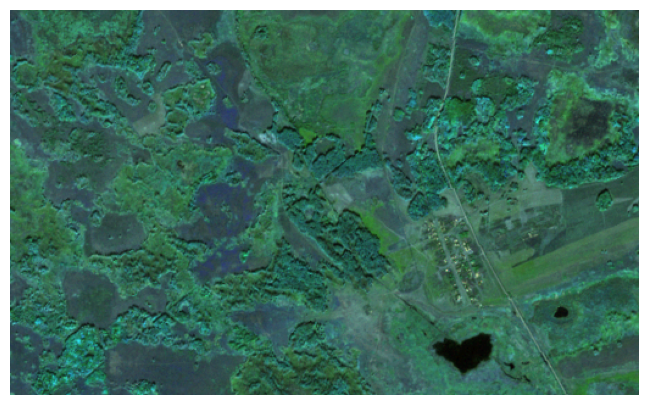

In [11]:
import os
import re
import numpy as np
import cv2
import rasterio
from matplotlib import pyplot as plt

def find_tiff_file(directory):
    """Находит первый .tiff файл в указанной директории с помощью регулярного выражения"""
    tiff_pattern = re.compile(r'.*\.tiff$')  # Регулярное выражение для поиска .tiff файлов
    for file_name in os.listdir(directory):
        if tiff_pattern.match(file_name):
            return os.path.join(directory, file_name)
    raise FileNotFoundError("TIFF файл не найден в указанной директории")

def normalize_band(band):
    """Нормализует данные канала в диапазоне 0-255"""
    band_min, band_max = band.min(), band.max()
    normalized_band = (band - band_min) / (band_max - band_min) * 255.0
    return normalized_band.astype(np.uint8)

def visualize_rgb_geotiff(directory, r_band, g_band, b_band, ik_band, mask_band):
    try:
        # Поиск .tiff файла в указанной папке
        file_path = find_tiff_file(directory)
        print(f"Обнаружен файл: {file_path}")

        with rasterio.open(file_path) as src:

            print(f"File Path: {file_path}")
            print(f"Driver: {src.driver}")
            print(f"Width: {src.width}")
            print(f"Height: {src.height}")
            print(f"Count (Bands): {src.count}")
            print(f"CRS: {src.crs}")
            print(f"Transform: {src.transform}")
            print(f"Bounding Box: {src.bounds}")
            print(f"Datum: {src.dtypes}")

            for i in range(1, src.count + 1):
                band = src.read(i)
                print(f"\nBand {i}:")
                print(f"  Data Type: {src.dtypes[i - 1]}")
                print(f"  Min Value: {band.min()}")
                print(f"  Max Value: {band.max()}")
                print(f"  Mean Value: {band.mean()}")
                print(f"  Standard Deviation: {band.std()}")
                
            # Проверка количества доступных каналов
            num_bands = src.count
            #if r_band > num_bands or g_band > num_bands or b_band > num_bands or ik_band > num_bands or mask_band > num_bands:
            #    raise ValueError("Номера каналов превышают количество доступных в файле.")

            # Чтение необходимых каналов
            red = src.read(r_band)
            green = src.read(g_band)
            blue = src.read(b_band)
            ik = src.read(ik_band)
            #mask = src.read(mask_band)

            # Нормализация каждого канала
            red_norm = normalize_band(red)
            green_norm = normalize_band(green)
            blue_norm = normalize_band(blue)
            ik_norm = normalize_band(ik)

            # Сборка 4-канального изображения
            photo_rgb_4channel = np.stack([red_norm, green_norm, blue_norm, ik_norm], axis=-1).astype(np.uint8)

            # Обработка маски
            #mask_stacked = (mask > 0).astype(np.uint8) * 255  # Преобразование маски в бинарную

            # Определение имени файлов для сохранения
            base_name = os.path.splitext(os.path.basename(file_path))[0]  # Имя файла без расширения
            output_dir = os.path.dirname(file_path)  # Получаем директорию исходного файла
            
            filename = os.path.join(output_dir, f"{base_name}_photo_rgb_4channel.png")  # Измените расширение на .png
            #filename_mask = os.path.join(output_dir, f"{base_name}_mask.jpg")
            print(photo_rgb_4channel.shape)
            # Сохранение файлов
            cv2.imwrite(filename, photo_rgb_4channel)
            #cv2.imwrite(filename_mask, mask_stacked)

            # Визуализация изображений
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.imshow(photo_rgb_4channel[:, :, :3])  # Показываем только первые 3 канала RGB
            ax.axis('off')
            plt.show()

            #fig, ax = plt.subplots(figsize=(5, 5))
            #ax.imshow(mask_stacked, cmap='gray')
            #ax.axis('off')
            #plt.show()

    except FileNotFoundError as fnf_error:
        print(fnf_error)
    except Exception as e:
        print(f'Ошибка: {e}')

# Директория с GeoTIFF файлами
directory = '/home/user/projects/co_hack_fires/test_dataset_minprirody_test_dataset/'
# Вызов функции для визуализации
visualize_rgb_geotiff(directory, 1, 2, 3, 4, 5)


## обучение нейронной сети

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform_image=None, transform_mask=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.images[idx])  # имена изображений и масок должны совпадать
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Маска - одноканальное изображение

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask


In [ ]:
resize = transforms.Resize((256, 256))
transform_image = transforms.Compose([
    resize,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_mask = transforms.Compose([
    resize,
    transforms.ToTensor()
])

In [ ]:
dataset = SegmentationDataset(
    images_dir='/home/user/projects/co_hack_fires/train/full/train/images/',
    masks_dir='/home/user/projects/co_hack_fires/train/full/train/masks/',
    transform_image=transform_image,
    transform_mask=transform_mask
)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
model = smp.Unet(encoder_name="efficientnet-b3", encoder_weights="imagenet", in_channels=4, classes=1)

In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
def pixel_accuracy(outputs, masks):
    outputs = (outputs > 0.5).float()
    correct = (outputs == masks).float().sum()
    total = torch.numel(masks)
    return correct / total

def calculate_iou(pred, target, threshold=0.5):
    pred = (pred > threshold).float()

    intersection = torch.sum((pred * target))

    union = torch.sum(pred) + torch.sum(target) - intersection
    
    if union == 0:
        return torch.tensor(1.0)
        
    iou = intersection / union
    return iou


In [ ]:
def split_dataset(dataset, val_split=0.2):
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

train_dataset, val_dataset = split_dataset(dataset, val_split=0.2)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [ ]:
# Функция для вычисления метрики MCC
def calculate_mcc(outputs, masks, threshold=0.5):
    outputs = (outputs > threshold).float()  # Приводим выходы модели к бинарному виду

    # TP, TN, FP, FN
    TP = torch.sum((outputs == 1) & (masks == 1)).float()
    TN = torch.sum((outputs == 0) & (masks == 0)).float()
    FP = torch.sum((outputs == 1) & (masks == 0)).float()
    FN = torch.sum((outputs == 0) & (masks == 1)).float()

    # Формула для вычисления MCC
    numerator = TP * TN - FP * FN
    denominator = torch.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    # Если знаменатель равен 0, возвращаем 0 (случай невозможности расчета MCC)
    mcc = numerator / (denominator + 1e-8)
    return mcc

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 100
# Функция для сохранения модели
def save_checkpoint(model, epoch, val_iou, save_path="best_model.pth"):
    torch.save({
        'model_state_dict': model.state_dict(),
    }, save_path)

import torch

# Функция для вычисления метрики MCC
def calculate_mcc(outputs, masks, threshold=0.5):
    outputs = (outputs > threshold).float()  # Приводим выходы модели к бинарному виду

    # TP, TN, FP, FN
    TP = torch.sum((outputs == 1) & (masks == 1)).float()
    TN = torch.sum((outputs == 0) & (masks == 0)).float()
    FP = torch.sum((outputs == 1) & (masks == 0)).float()
    FN = torch.sum((outputs == 0) & (masks == 1)).float()

    # Формула для вычисления MCC
    numerator = TP * TN - FP * FN
    denominator = torch.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    # Если знаменатель равен 0, возвращаем 0 (случай невозможности расчета MCC)
    mcc = numerator / (denominator + 1e-8)
    return mcc

# Добавляем расчет MCC в тренировочный и валидационный цикл
model.to(device)

num_epochs = 1000
best_val_pixel_acc = 0.0  # Начальное значение для отслеживания лучшей точности
save_path = "best_model.pth"

for epoch in range(num_epochs):
    # --- ТРЕНИРОВОЧНЫЙ ЦИКЛ ---
    model.train()
    running_loss = 0.0
    iou_score = 0.0
    pixel_acc = 0.0
    mcc_score = 0.0  # Для подсчета MCC
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        batch_iou = 0.0
        batch_mcc = 0.0  # Для батча MCC

        for i in range(images.size(0)):  # Проходим по каждому изображению в батче
            iou = calculate_iou(outputs[i], masks[i])
            batch_iou += iou.item()

            # Расчет MCC
            mcc = calculate_mcc(outputs[i], masks[i])
            batch_mcc += mcc.item()

        iou_score += batch_iou / images.size(0)
        mcc_score += batch_mcc / images.size(0)  # Средний MCC по батчу

        # Pixel accuracy
        pixel_acc += pixel_accuracy(outputs, masks).item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_iou = iou_score / len(train_loader)  # IoU на батчах
    epoch_pixel_acc = pixel_acc / len(train_loader.dataset)
    epoch_mcc = mcc_score / len(train_loader)  # MCC на батчах

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train IoU: {epoch_iou:.4f}, Train MCC: {epoch_mcc:.4f}, Train Pixel Accuracy: {epoch_pixel_acc:.4f}")
    
    # --- ВАЛИДАЦИОННЫЙ ЦИКЛ ---
    model.eval()
    val_loss = 0.0
    val_iou_score = 0.0
    val_pixel_acc = 0.0
    val_mcc_score = 0.0  # Для MCC на валидации
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item() * images.size(0)

            batch_iou = 0.0
            batch_mcc = 0.0  # Для батча MCC

            for i in range(images.size(0)):  # Проходим по каждому изображению в батче
                iou = calculate_iou(outputs[i], masks[i])
                batch_iou += iou.item()

                # Расчет MCC
                mcc = calculate_mcc(outputs[i], masks[i])
                batch_mcc += mcc.item()

            val_iou_score += batch_iou / images.size(0)
            val_mcc_score += batch_mcc / images.size(0)  # Средний MCC по батчу

            # Pixel accuracy
            val_pixel_acc += pixel_accuracy(outputs, masks).item() * images.size(0)
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_iou = val_iou_score / len(val_loader)  # IoU на батчах
    epoch_val_pixel_acc = val_pixel_acc / len(val_loader.dataset)
    epoch_val_mcc = val_mcc_score / len(val_loader)  # MCC на батчах

    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {epoch_val_loss:.4f}, Val IoU: {epoch_val_iou:.4f}, Val MCC: {epoch_val_mcc:.4f}, Val Pixel Accuracy: {epoch_val_pixel_acc:.4f}")

    # Сохранение модели при улучшении точности пикселей на валидации
    if epoch_val_pixel_acc > best_val_pixel_acc:
        best_val_pixel_acc = epoch_val_pixel_acc
        save_checkpoint(model, epoch+1, best_val_pixel_acc, save_path)
        print(f"New best model found and saved at epoch {epoch+1} with Pixel Accuracy: {best_val_pixel_acc:.4f}")


## validation for model 3 channel

In [ ]:
import torch
import segmentation_models_pytorch as smp

# Инициализация модели
model = smp.Unet(encoder_name="efficientnet-b3", encoder_weights=None, in_channels=3, classes=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Путь к файлу с весами
weights_path = "/home/user/projects/co_hack_fires/forest-fires/best_model.pth"

# Загрузка весов
model.load_state_dict(torch.load(weights_path, map_location=device), strict=False)

# Перевод модели на соответствующее устройство
model.to(device)

516 316


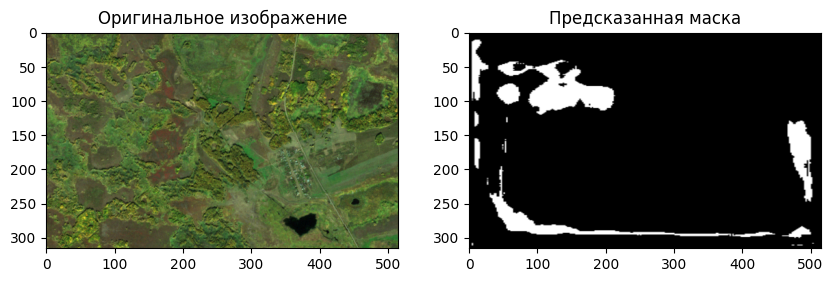

In [16]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def predict_image(model, image_path, device):
    image = Image.open(image_path).convert('RGB')

    H, W = image.size
    print(H,W)
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Изменение размера изображения
        transforms.ToTensor(),          # Преобразование в тензор
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Нормализация
    ])
    
    image = transform(image).unsqueeze(0)  # Добавление batch size
    
    image = image.to(device)
    
    model.eval()
    
    with torch.no_grad():
        # Предсказание
        output = model(image)
    
    pred_mask = output.squeeze().cpu().numpy()  # Извлечение тензора и перевод на CPU
    pred_mask = (pred_mask > 0.05).astype('uint8')  # Бинаризация маски
    pred_mask = pred_mask * 255
    pred_mask = cv2.resize(pred_mask, (H, W)) 
    return pred_mask

# Визуализация оригинального изображения и предсказанной маски
def display_results(image_path, pred_mask):
    image = Image.open(image_path).convert('RGB')
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].imshow(image)
    axs[0].set_title('Оригинальное изображение')
    axs[1].imshow(pred_mask, cmap='gray')
    axs[1].set_title('Предсказанная маска')
    
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

image_path = "/home/user/projects/co_hack_fires/test_dataset_minprirody_test_dataset/test_photo_rgb_4channel.png"

predicted_mask = predict_image(model, image_path, device)

display_results(image_path, predicted_mask)

## valid for model 4 channel

516 316


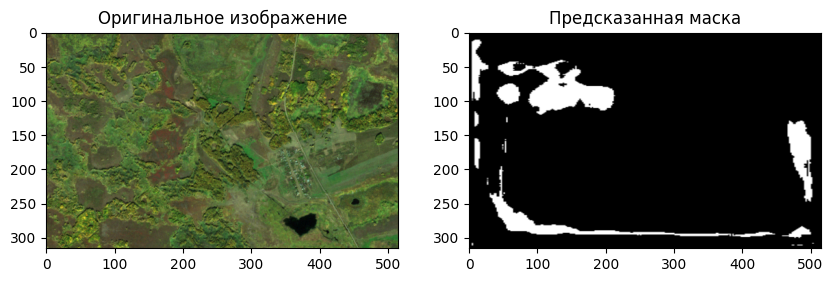

In [21]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def predict_image(model, image_path, device):
    # Открываем изображение и добавляем дополнительный канал
    image = Image.open(image_path).convert('RGB')

    # Преобразуем изображение в массив и добавляем дополнительный канал
    image_array = np.array(image)
    additional_channel = np.zeros_like(image_array[:, :, :1])  # Создаем пустой канал
    image_array = np.concatenate([image_array, additional_channel], axis=-1)  # Добавляем канал

    # Преобразуем массив обратно в изображение
    image = Image.fromarray(image_array, 'RGBA')

    H, W = image.size
    print(H, W)
    
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Изменение размера изображения
        transforms.ToTensor(),          # Преобразование в тензор
        transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.0], std=[0.229, 0.224, 0.225, 0.001]),  # Нормализация
    ])
    
    image = transform(image).unsqueeze(0)  # Добавление batch size
    
    image = image.to(device)
    
    model.eval()
    
    with torch.no_grad():
        # Предсказание
        output = model(image)
    
    pred_mask = output.squeeze().cpu().numpy()  # Извлечение тензора и перевод на CPU
    pred_mask = (pred_mask > 0.5).astype('uint8')  # Бинаризация маски
    pred_mask = pred_mask * 255
    pred_mask = cv2.resize(pred_mask, (H, W)) 
    return pred_mask

# Визуализация оригинального изображения и предсказанной маски
def display_results(image_path, pred_mask):
    image = Image.open(image_path).convert('RGB')
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].imshow(image)
    axs[0].set_title('Оригинальное изображение')
    axs[1].imshow(pred_mask, cmap='gray')
    axs[1].set_title('Предсказанная маска')
    
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

image_path = "/home/user/projects/co_hack_fires/test_dataset_minprirody_test_dataset/test_photo_rgb_4channel.png"

predicted_mask = predict_image(model, image_path, device)

display_results(image_path, predicted_mask)

In [22]:
def save_mask_as_csv(pred_mask, output_csv_path):
    # Преобразуем маску в значения 0 и 1 (если она содержит 0 и 255)
    binary_mask = (pred_mask > 0).astype(int)
    
    # Преобразуем бинарную маску в DataFrame
    df = pd.DataFrame(binary_mask)
    
    # Сохраняем DataFrame в CSV
    df.to_csv(output_csv_path, index=False, header=False)
    print(f"Маска успешно сохранена в {output_csv_path}")

# Используем вашу предсказанную маску
output_csv_path = "/home/user/projects/co_hack_fires/predicted_mask_3.csv"
save_mask_as_csv(predicted_mask, output_csv_path)


Маска успешно сохранена в /home/user/projects/co_hack_fires/predicted_mask_3.csv


In [ ]:
mask_path = "/home/user/projects/co_hack_fires/train/full/train/masks/0.jpg"
mask_orig= Image.open(mask_path).convert('RGB')

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(mask_orig)
ax.axis('off')
plt.show()

## Переписываем сеть

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc_conv1 = self.double_conv(in_channels, 64)
        self.enc_conv2 = self.double_conv(64, 128)
        self.enc_conv3 = self.double_conv(128, 256)
        self.enc_conv4 = self.double_conv(256, 512)
        
        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec_conv4 = self.double_conv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_conv3 = self.double_conv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv2 = self.double_conv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv1 = self.double_conv(128, 64)
        
        # Output
        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc_conv1(x)
        enc2 = self.enc_conv2(F.max_pool2d(enc1, kernel_size=2, stride=2))
        enc3 = self.enc_conv3(F.max_pool2d(enc2, kernel_size=2, stride=2))
        enc4 = self.enc_conv4(F.max_pool2d(enc3, kernel_size=2, stride=2))
        
        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2, stride=2))
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)  # Skip connection
        dec4 = self.dec_conv4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec_conv3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec_conv2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec_conv1(dec1)
        
        # Output
        output = self.output_conv(dec1)
        return output

# Пример инициализации модели
model = UNet(in_channels=3, out_channels=1)

# Остальная часть кода для обучения может остаться такой же
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Пробуем юнет с эмбеддингом

## pandas embeddings tabl csv

In [ ]:
import pandas as pd

# Загрузка CSV файла
df = pd.read_csv("/home/user/projects/co_hack_fires/train/00/2021-06-06_weather.csv")

# Просмотр первых нескольких строк
df.head()

In [ ]:
df = df.drop(['Порывы ветра', 'Дата'], axis=1)

In [ ]:
df.tail()

In [ ]:

# Преобразование DataFrame в тензор PyTorch
X = torch.tensor(df.values, dtype=torch.float32)

# Определение модели
class EmbeddingModel(nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.fc1 = nn.Linear(in_features=df.shape[1], out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=128)
        self.fc4 = nn.Linear(in_features=128, out_features=1000)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Создание модели и получение эмбеддингов
model = EmbeddingModel()
embeddings = model(X)

# Присвоение весов строкам: большее значение весов для более низких строк
weights = torch.arange(1, len(df) + 1, dtype=torch.float32)
weights = weights / weights.sum()  # Нормализация весов, чтобы сумма весов была 1

# Применение весов и вычисление взвешенного среднего
weighted_embeddings = (embeddings * weights.view(-1, 1)).sum(dim=0, keepdim=True)
_, weighted_embedding_dim = weighted_embeddings.shape
print(weighted_embedding_dim)
print("Размер финального эмбеддинга:", weighted_embeddings.shape)
print("Финальный эмбеддинг:", weighted_embeddings)

## completed unet with csv embeddings in latent space

In [ ]:
import pandas as pd
import cv2
import numpy as np

# Прочитайте табличные данные
df = pd.read_csv('/home/user/projects/co_hack_fires/train/00/2021-06-06_weather.csv')
df = df.drop(['Порывы ветра', 'Дата'], axis=1)
# Удаление столбцов с нечисловыми данными
df = df.select_dtypes(include=[float, int])


In [ ]:
df.tail()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Удаление строк с NaN значениями
df_cleaned = df.dropna()
# Инициализация нормализатора
scaler = MinMaxScaler()

# Нормализация значений
df_normalized = scaler.fit_transform(df)


In [ ]:
# Преобразование нормализованных данных в матрицу
matrix = np.array(df_normalized, dtype=np.float32)

# Размеры изображения (например, 256x256)
img_height, img_width = 256, 256

# Изменение размера матрицы
matrix_resized = cv2.resize(matrix, (img_width, img_height), interpolation=cv2.INTER_LINEAR)

# Убедитесь, что матрица имеет 4 канала, если необходимо
# Например, добавляем размерности для изображения
matrix_resized = np.expand_dims(matrix_resized, axis=0)  # Добавляем размерность для "batch"
matrix_resized = np.expand_dims(matrix_resized, axis=0)  # Добавляем размерность для "channels" (если требуется)
matrix_resized

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import cv2

# Шаг 1: Чтение данных из CSV-файла
df = pd.read_csv('/home/user/projects/co_hack_fires/train/00/2021-06-06_weather.csv')

# Удаление ненужных столбцов
df = df.drop(['Порывы ветра', 'Дата'], axis=1)

# Оставляем только числовые данные (float, int)
df = df.select_dtypes(include=[float, int])

# Проверяем, что DataFrame не пуст
if df.empty:
    raise ValueError("DataFrame пуст после удаления NaN значений")

# Шаг 2: Нормализация данных в диапазоне [0, 1] и масштабирование до [0, 255]
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df)

# Масштабирование значений в диапазоне [0, 255]
df_normalized = df_normalized * 255

# Преобразование нормализованных данных в матрицу
matrix = np.array(df_normalized, dtype=np.float32)

# Шаг 3: Изменение размера матрицы под указанные размеры (215x222)
# Размеры целевого изображения
target_height, target_width = 215, 222

# Изменение размера матрицы
matrix_resized = cv2.resize(matrix, (215, 222), interpolation=cv2.INTER_LINEAR)

# Шаг 4: Преобразование результата обратно в DataFrame и сохранение в CSV
df_resized = pd.DataFrame(matrix_resized)

# Сохранение в новый CSV файл
df_resized.to_csv('/home/user/projects/co_hack_fires/train/00/resized_matrix.csv', index=False)

print("Матрица успешно сохранена в CSV файл с новыми размерами.")
matrix_resized.shape = (1,215,222)

In [ ]:
df = pd.read_csv('/home/user/projects/co_hack_fires/train/00/2021-06-06_weather.csv')

df = df.drop(['Порывы ветра', 'Дата'], axis=1)

df = df.select_dtypes(include=[float, int])

# Проверьте, есть ли данные после удаления NaN
if df.empty:
    raise ValueError("DataFrame пуст после удаления NaN значений")

# Нормализация значений в диапазоне [0, 1]
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df)

# Масштабирование значений в диапазоне [0, 255]
df_normalized = df_normalized * 255

# Преобразование нормализованных данных в матрицу
matrix = np.array(df_normalized, dtype=np.float32)
mask_path = "/home/user/projects/co_hack_fires/train/full/train/images/0.jpg"
mask_orig= Image.open(mask_path).convert('RGB')
img_height, img_width = mask_orig.size
# Размеры изображения (например, 256x256)
#img_height, img_width = 256, 256

# Если матрица имеет меньше строк, чем требуется, повторите строки или заполните
if matrix.shape[0] < img_height:
    padding = np.zeros((img_height - matrix.shape[0], matrix.shape[1]), dtype=np.float32)
    matrix = np.vstack([matrix, padding])

# Изменение размера матрицы
matrix_resized = cv2.resize(matrix, (215, 222), interpolation=cv2.INTER_LINEAR)

# Убедитесь, что матрица имеет 4 канала, если необходимо
# Например, добавляем размерности для изображения
matrix_resized = np.expand_dims(matrix_resized, axis=0)  # Добавляем размерность для "batch"
matrix_resized = np.expand_dims(matrix_resized, axis=0)  # Добавляем размерность для "channels" (если требуется)
matrix_resized.shape

In [ ]:
from torchvision import transforms

# Пример загрузки изображения
image_path = '/home/user/projects/co_hack_fires/train/full/train/images/0.jpg'
image = Image.open(image_path).convert('RGB')

# Преобразуем изображение в тензор
transform = transforms.ToTensor()
image_tensor = transform(image)  # Это будет тензор с размерностью (3, H, W)
print(image_tensor.shape)  # Теперь изображение с дополнительным каналом


# Удалим лишнюю размерность из матрицы (1, 1, 215, 222)
matrix_resized = matrix_resized.squeeze(0)  # Теперь (1, 215, 222)

# Убедитесь, что размеры совпадают, иначе выполните изменение размера
_, img_height, img_width = image_tensor.shape
matrix_resized = torch.tensor(cv2.resize(matrix_resized[0], (img_width, img_height)))

# Объединяем матрицу с изображением по оси каналов
combined_tensor = torch.cat([image_tensor, matrix_resized.unsqueeze(0)], dim=0)  # Размер будет (4, H, W)

print(combined_tensor.shape)  # Теперь изображение с дополнительным каналом


In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Преобразование тензора обратно в PIL изображение для визуализации RGB каналов
transform_to_pil = transforms.ToPILImage()

# Извлекаем первые три канала (RGB)
rgb_image_tensor = combined_tensor[:3, :, :]  # Размер (3, H, W)
rgb_image = transform_to_pil(rgb_image_tensor)  # Преобразуем обратно в изображение

# Извлекаем четвертый канал для визуализации как отдельную маску
fourth_channel = combined_tensor[3, :, :].cpu().numpy()  # Размер (H, W)

# Визуализируем
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Визуализация RGB изображения
axs[0].imshow(rgb_image)
axs[0].set_title('RGB изображение')

# Визуализация 4-го канала (в градациях серого)
axs[1].imshow(fourth_channel, cmap='gray')
axs[1].set_title('4-й канал')

plt.show()


## Обучение в 4 канала

In [3]:
import os
import re
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import rasterio
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import segmentation_models_pytorch as smp
from torchvision import transforms

class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform_image=None, transform_mask=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.images[idx])  # имена изображений и масок должны совпадать
        image = Image.open(img_path)
        mask = Image.open(mask_path).convert("L")  # Маска - одноканальное изображение

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

resize = transforms.Resize((256, 256))
transform_image = transforms.Compose([
    resize,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.5], std=[0.229, 0.224, 0.225, 0.5])  # Задайте свои значения
])
transform_mask = transforms.Compose([
    resize,
    transforms.ToTensor()
])

# Создание набора данных и загрузчиков данных
dataset = SegmentationDataset(
    images_dir='/home/user/projects/co_hack_fires/train/train_dataset_train_correct_2/full/images/',
    masks_dir='/home/user/projects/co_hack_fires/train/train_dataset_train_correct_2/full/masks/',
    transform_image=transform_image,
    transform_mask=transform_mask
)

# Функция для разбиения набора данных на обучающий и валидационный
def split_dataset(dataset, val_split=0.2):
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

train_dataset, val_dataset = split_dataset(dataset, val_split=0.2)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Обновляем модель для 4-канальных изображений
model = smp.Unet(encoder_name="efficientnet-b3", encoder_weights="imagenet", in_channels=4, classes=1)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


# Проверка и корректировка метрик
def pixel_accuracy(outputs, masks):
    outputs = torch.sigmoid(outputs)  # Применение сигмоида
    outputs = (outputs > 0.5).float()
    correct = (outputs == masks).float().sum()
    total = torch.numel(masks)
    return correct / total


def calculate_iou(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = torch.sum((pred * target))
    union = torch.sum(pred) + torch.sum(target) - intersection
    if union == 0:
        return torch.tensor(1.0)
    iou = intersection / union
    return iou

def calculate_mcc(outputs, masks, threshold=0.5):
    outputs = (outputs > threshold).float()
    TP = torch.sum((outputs == 1) & (masks == 1)).float()
    TN = torch.sum((outputs == 0) & (masks == 0)).float()
    FP = torch.sum((outputs == 1) & (masks == 0)).float()
    FN = torch.sum((outputs == 0) & (masks == 1)).float()
    numerator = TP * TN - FP * FN
    denominator = torch.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    mcc = numerator / (denominator + 1e-8)
    return mcc

# Функция для сохранения модели
def save_checkpoint(model, epoch, val_iou, save_path="best_model.pth"):
    torch.save({
        'model_state_dict': model.state_dict(),
    }, save_path)

# Обучение модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 1000
best_val_pixel_acc = 0.0
save_path = "best_model.pth"

# Обновление обучения и проверки
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    iou_score = 0.0
    pixel_acc = 0.0
    mcc_score = 0.0
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
        batch_iou = 0.0
        batch_mcc = 0.0
        
        for i in range(images.size(0)):
            iou = calculate_iou(outputs[i].cpu(), masks[i].cpu())
            batch_iou += iou.item()

            mcc = calculate_mcc(outputs[i].cpu(), masks[i].cpu())
            batch_mcc += mcc.item()

        iou_score += batch_iou / images.size(0)
        mcc_score += batch_mcc / images.size(0)
        pixel_acc += pixel_accuracy(outputs, masks).item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_iou = iou_score / len(train_loader)
    epoch_pixel_acc = pixel_acc / len(train_loader.dataset)
    epoch_mcc = mcc_score / len(train_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train IoU: {epoch_iou:.4f}, Train MCC: {epoch_mcc:.4f}, Train Pixel Accuracy: {epoch_pixel_acc:.4f}")
    
    model.eval()
    val_loss = 0.0
    val_iou_score = 0.0
    val_pixel_acc = 0.0
    val_mcc_score = 0.0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item() * images.size(0)
            
            batch_iou = 0.0
            batch_mcc = 0.0
            
            for i in range(images.size(0)):
                iou = calculate_iou(outputs[i].cpu(), masks[i].cpu())
                batch_iou += iou.item()

                mcc = calculate_mcc(outputs[i].cpu(), masks[i].cpu())
                batch_mcc += mcc.item()

            val_iou_score += batch_iou / images.size(0)
            val_mcc_score += batch_mcc / images.size(0)
            val_pixel_acc += pixel_accuracy(outputs, masks).item() * images.size(0)
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_iou = val_iou_score / len(val_loader)
    epoch_val_pixel_acc = val_pixel_acc / len(val_loader.dataset)
    epoch_val_mcc = val_mcc_score / len(val_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {epoch_val_loss:.4f}, Val IoU: {epoch_val_iou:.4f}, Val MCC: {epoch_val_mcc:.4f}, Val Pixel Accuracy: {epoch_val_pixel_acc:.4f}")
    
    if epoch_val_pixel_acc > best_val_pixel_acc:
        best_val_pixel_acc = epoch_val_pixel_acc
        save_checkpoint(model, epoch+1, best_val_pixel_acc, save_path)
        print(f"New best model found and saved at epoch {epoch+1} with Pixel Accuracy: {best_val_pixel_acc:.4f}")


Epoch 1/1000, Train Loss: 0.8003, Train IoU: 0.0563, Train MCC: 0.0002, Train Pixel Accuracy: 0.3245
Epoch 1/1000, Val Loss: 0.7795, Val IoU: 0.0615, Val MCC: -0.0027, Val Pixel Accuracy: 0.1873
New best model found and saved at epoch 1 with Pixel Accuracy: 0.1873
Epoch 2/1000, Train Loss: 0.7679, Train IoU: 0.0534, Train MCC: 0.0063, Train Pixel Accuracy: 0.3617
Epoch 2/1000, Val Loss: 0.7883, Val IoU: 0.0782, Val MCC: 0.0431, Val Pixel Accuracy: 0.1875
New best model found and saved at epoch 2 with Pixel Accuracy: 0.1875
Epoch 3/1000, Train Loss: 0.7499, Train IoU: 0.0496, Train MCC: 0.0055, Train Pixel Accuracy: 0.3798
Epoch 3/1000, Val Loss: 0.7032, Val IoU: 0.0525, Val MCC: 0.0383, Val Pixel Accuracy: 0.3431
New best model found and saved at epoch 3 with Pixel Accuracy: 0.3431
Epoch 4/1000, Train Loss: 0.7263, Train IoU: 0.0497, Train MCC: 0.0099, Train Pixel Accuracy: 0.4024
Epoch 4/1000, Val Loss: 0.6415, Val IoU: 0.0383, Val MCC: 0.0254, Val Pixel Accuracy: 0.4581
New best mode

KeyboardInterrupt: 

In [ ]:
import os

def rename_files_to_png(directory):
    # Получаем список всех файлов в директории
    for filename in os.listdir(directory):
        # Полный путь к текущему файлу
        old_file = os.path.join(directory, filename)
        
        # Проверяем, что это файл (а не директория)
        if os.path.isfile(old_file):
            # Получаем имя файла без расширения
            base_name, _ = os.path.splitext(filename)
            
            # Создаем новое имя файла с расширением .png
            new_file = os.path.join(directory, f"{base_name}.png")
            
            # Переименовываем файл
            os.rename(old_file, new_file)
            print(f"Переименован: {old_file} -> {new_file}")

# Замените эту строку на путь к вашей директории
directory_path = '/home/user/projects/co_hack_fires/train/train_dataset_train_correct_2/full/masks/'
rename_files_to_png(directory_path)
